States shape: (10000, 3)
Actions shape: (10000, 1)
Profits shape: (10000, 1)
Training data shapes:
states_t: torch.Size([9999, 3])
actions_t: torch.Size([9999, 1])
next_states_t: torch.Size([9999, 3])
rewards_t: torch.Size([9999, 1])
Predicted next_states shape: torch.Size([9999, 3])
Predicted rewards shape: torch.Size([9999, 1])
Epoch [10/50], Loss: 49.8508
Epoch [20/50], Loss: 46.3772
Epoch [30/50], Loss: 42.3923
Epoch [40/50], Loss: 37.7693
Epoch [50/50], Loss: 32.6083

=== Counterfactual Control Analysis ===


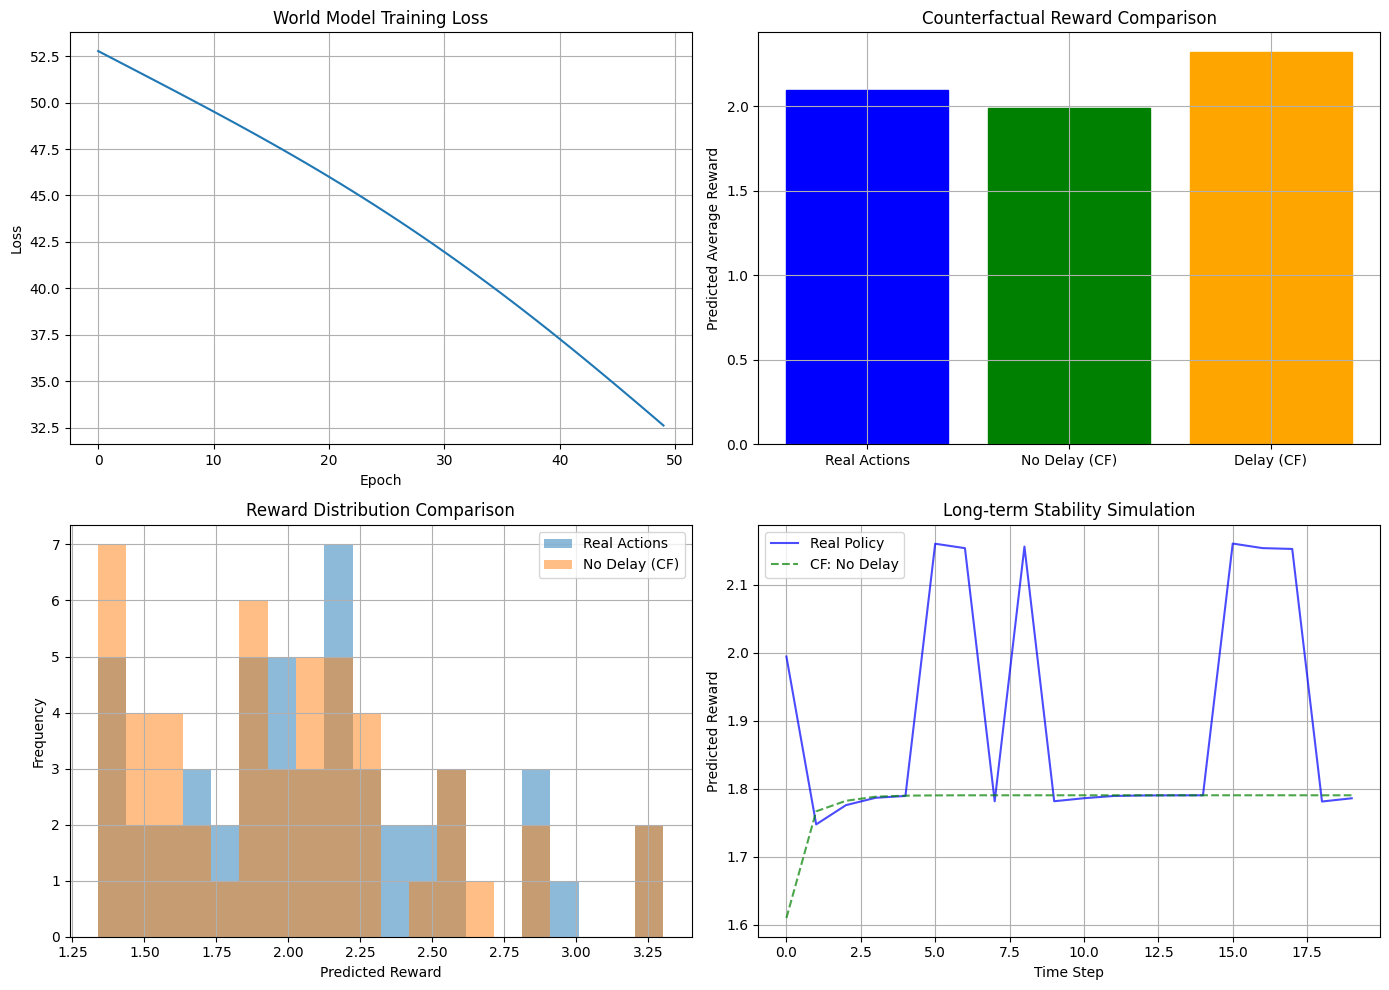


=== Analysis Results ===
Average predicted reward with real actions: 2.09
Average predicted reward with counterfactual (no delay): 1.99
Average predicted reward with counterfactual (delay): 2.32

Percentage improvement relative to real strategy:
Always no delay strategy: -5.0%
Always delay strategy: 10.8%

Long-term stability analysis:
Real policy reward standard deviation: 0.171
Counterfactual policy reward standard deviation: 0.039
Counterfactual policy (no delay) shows better long-term stability!

Counterfactual control helps evaluate the long-term stability and potential value of unchosen strategies.


In [5]:
# counterfactual_world_model.py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class WorldModel(nn.Module):
    """
    Function: Self-supervised world model that predicts the next state and reward.
    Input: Current state (3 dimensions) + Action (1 dimension)
    Output: Next state prediction (3 dimensions) + Reward prediction (1 dimension)
    """
    def __init__(self, state_dim=3, action_dim=1, hidden=32):
        super().__init__()
        self.input_dim = state_dim + action_dim  # 3 + 1 = 4
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, hidden),  # Input should be 4-dimensional
            nn.ReLU(),
            nn.Linear(hidden, hidden)
        )
        self.state_decoder = nn.Linear(hidden, state_dim)
        self.reward_decoder = nn.Linear(hidden, 1)

    def forward(self, state, action):
        # Ensure the action dimension is correct
        if action.dim() == 1:
            action = action.unsqueeze(1)
        x = torch.cat([state, action], dim=1)
        h = self.encoder(x)
        next_state_pred = self.state_decoder(h)
        reward_pred = self.reward_decoder(h)
        return next_state_pred, reward_pred

def train_world_model_with_counterfactual(data_path='fastship_dataset.csv', epochs=50):
    """
    Function: Train a self-supervised world model and incorporate counterfactual control to analyze long-term stability.
    Input:
        data_path: Dataset file path
        epochs: Number of training epochs
    Output:
        Training loss curve, comparison chart of counterfactual intervention effects
    """
    df = pd.read_csv(data_path)

    # Data preprocessing
    states = df[['weather', 'traffic', 'maintenance_flag']].values
    actions = df['delay_decision'].values.reshape(-1, 1)  # Maintain 2D shape
    profits = df['profit'].values.reshape(-1, 1)

    # Ensure data shapes are correct
    print(f"States shape: {states.shape}")
    print(f"Actions shape: {actions.shape}")
    print(f"Profits shape: {profits.shape}")

    # Use all data but maintain sequential relationships
    states_t = torch.FloatTensor(states[:-1])
    actions_t = torch.FloatTensor(actions[:-1])
    next_states_t = torch.FloatTensor(states[1:])
    rewards_t = torch.FloatTensor(profits[:-1])

    print(f"Training data shapes:")
    print(f"states_t: {states_t.shape}")
    print(f"actions_t: {actions_t.shape}")
    print(f"next_states_t: {next_states_t.shape}")
    print(f"rewards_t: {rewards_t.shape}")

    model = WorldModel()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        next_state_pred, reward_pred = model(states_t, actions_t)

        # Validate output shapes
        if epoch == 0:
            print(f"Predicted next_states shape: {next_state_pred.shape}")
            print(f"Predicted rewards shape: {reward_pred.shape}")

        loss_state = criterion(next_state_pred, next_states_t)
        loss_reward = criterion(reward_pred, rewards_t)
        loss = loss_state + loss_reward

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Counterfactual control analysis
    print("\n=== Counterfactual Control Analysis ===")
    test_states = states_t[:50]  # Use more samples for more reliable analysis
    test_actions = actions_t[:50]

    # Predictions with real actions
    _, real_rewards = model(test_states, test_actions)

    # Counterfactual action 1: All set to no delay (0)
    cf_actions_0 = torch.zeros_like(test_actions)
    _, cf_rewards_0 = model(test_states, cf_actions_0)

    # Counterfactual action 2: All set to delay (1)
    cf_actions_1 = torch.ones_like(test_actions)
    _, cf_rewards_1 = model(test_states, cf_actions_1)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Training loss
    axes[0, 0].plot(losses)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('World Model Training Loss')
    axes[0, 0].grid(True)

    # Counterfactual reward comparison
    actions_labels = ['Real Actions', 'No Delay (CF)', 'Delay (CF)']
    rewards_values = [
        real_rewards.mean().item(),
        cf_rewards_0.mean().item(),
        cf_rewards_1.mean().item()
    ]

    bars = axes[0, 1].bar(actions_labels, rewards_values)
    axes[0, 1].set_ylabel('Predicted Average Reward')
    axes[0, 1].set_title('Counterfactual Reward Comparison')
    axes[0, 1].grid(True)

    # Set different colors for different bars
    bars[0].set_color('blue')
    bars[1].set_color('green')
    bars[2].set_color('orange')

    # Reward distribution comparison
    axes[1, 0].hist(real_rewards.detach().numpy().flatten(), alpha=0.5, label='Real Actions', bins=20)
    axes[1, 0].hist(cf_rewards_0.detach().numpy().flatten(), alpha=0.5, label='No Delay (CF)', bins=20)
    axes[1, 0].set_xlabel('Predicted Reward')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Reward Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Long-term stability analysis: Simulate multiple time steps
    axes[1, 1].set_title('Long-term Stability Simulation')

    # Select initial state
    init_state = test_states[0:1]

    # Simulate long-term effects of two strategies
    n_steps = 20
    rewards_real = []
    rewards_cf = []

    state_real = init_state.clone()
    state_cf = init_state.clone()

    for step in range(n_steps):
        # Real policy (random actions)
        if step < len(test_actions):
            action_real = test_actions[step:step+1]
        else:
            action_real = torch.FloatTensor([[0.5]])  # Default action

        # Counterfactual policy (always no delay)
        action_cf = torch.zeros_like(action_real)

        # Predict next step
        next_state_real, reward_real = model(state_real, action_real)
        next_state_cf, reward_cf = model(state_cf, action_cf)

        rewards_real.append(reward_real.item())
        rewards_cf.append(reward_cf.item())

        # Update state (simplified: use predicted state)
        state_real = next_state_real.detach()
        state_cf = next_state_cf.detach()

    axes[1, 1].plot(range(n_steps), rewards_real, 'b-', label='Real Policy', alpha=0.7)
    axes[1, 1].plot(range(n_steps), rewards_cf, 'g--', label='CF: No Delay', alpha=0.7)
    axes[1, 1].set_xlabel('Time Step')
    axes[1, 1].set_ylabel('Predicted Reward')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('counterfactual_world_model.png', dpi=150)
    plt.show()

    # Output analysis results
    print(f"\n=== Analysis Results ===")
    print(f"Average predicted reward with real actions: {rewards_values[0]:.2f}")
    print(f"Average predicted reward with counterfactual (no delay): {rewards_values[1]:.2f}")
    print(f"Average predicted reward with counterfactual (delay): {rewards_values[2]:.2f}")

    improvement_0 = ((rewards_values[1] - rewards_values[0]) / abs(rewards_values[0])) * 100
    improvement_1 = ((rewards_values[2] - rewards_values[0]) / abs(rewards_values[0])) * 100

    print(f"\nPercentage improvement relative to real strategy:")
    print(f"Always no delay strategy: {improvement_0:.1f}%")
    print(f"Always delay strategy: {improvement_1:.1f}%")

    # Stability analysis
    real_std = np.std(rewards_real)
    cf_std = np.std(rewards_cf)
    print(f"\nLong-term stability analysis:")
    print(f"Real policy reward standard deviation: {real_std:.3f}")
    print(f"Counterfactual policy reward standard deviation: {cf_std:.3f}")

    if cf_std < real_std:
        print("Counterfactual policy (no delay) shows better long-term stability!")
    else:
        print("The real policy may be more stable in some cases.")

    print("\nCounterfactual control helps evaluate the long-term stability and potential value of unchosen strategies.")

if __name__ == '__main__':
    train_world_model_with_counterfactual()